In [386]:
import numpy as np
import cvxpy as cp
from scipy.spatial import HalfspaceIntersection

import plotly.graph_objects as go

In [168]:
## CVXPY MIQP example:

# Generate a random problem
np.random.seed(0)
m, n= 40, 25

A = np.random.rand(m, n)
b = np.random.randn(m)

# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
prob = cp.Problem(objective)
prob.solve()

print("Status: ", prob.status)
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)
print(f"Setup time: {prob.solver_stats.setup_time}, Solution time: {prob.solver_stats.solve_time}")

Status:  optimal
The optimal value is 13.660003251555075
A solution x is
[-1.  1.  1. -1.  0.  0. -1. -2.  0.  0.  0.  1.  1.  0.  1.  0. -1. -1.
 -1.  0.  2. -1.  2.  0. -1.]
Setup time: None, Solution time: None


Problem Formulation | Interger Constraints
- | - 
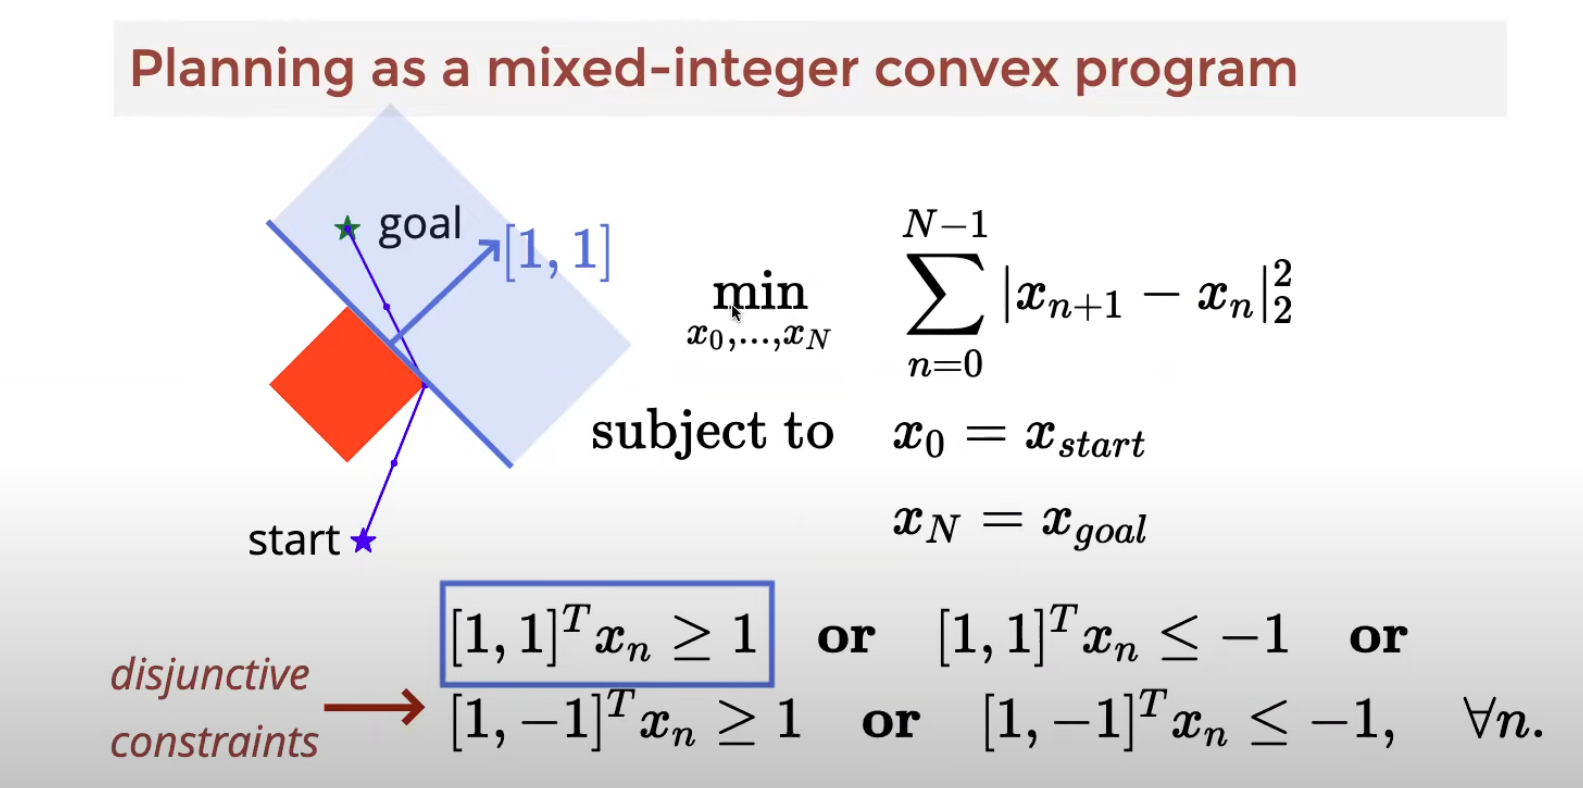 | 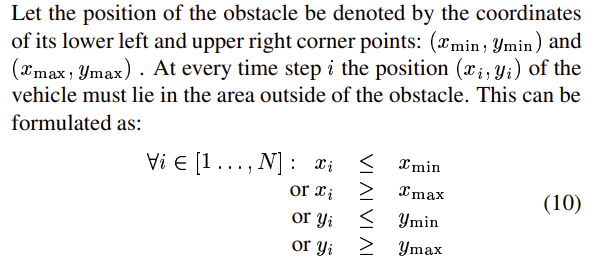 <br> 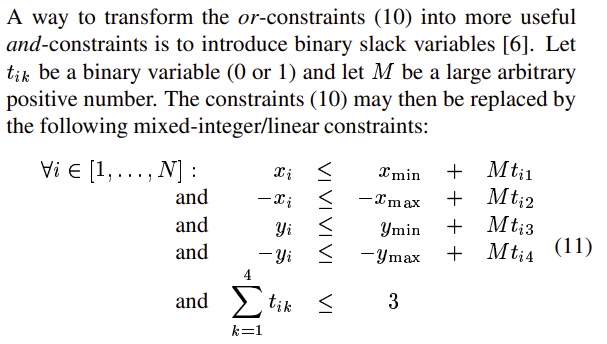


Status:  optimal
The optimal cost is 51.000000000010004
A solution x is
[[ 0.   0.5  0. ]
 [-5.   0.5  5. ]]
Optimal s:
[[ 1.  0.  1.]
 [ 1.  1.  1.]
 [-0.  1.  1.]
 [ 1.  1. -0.]]


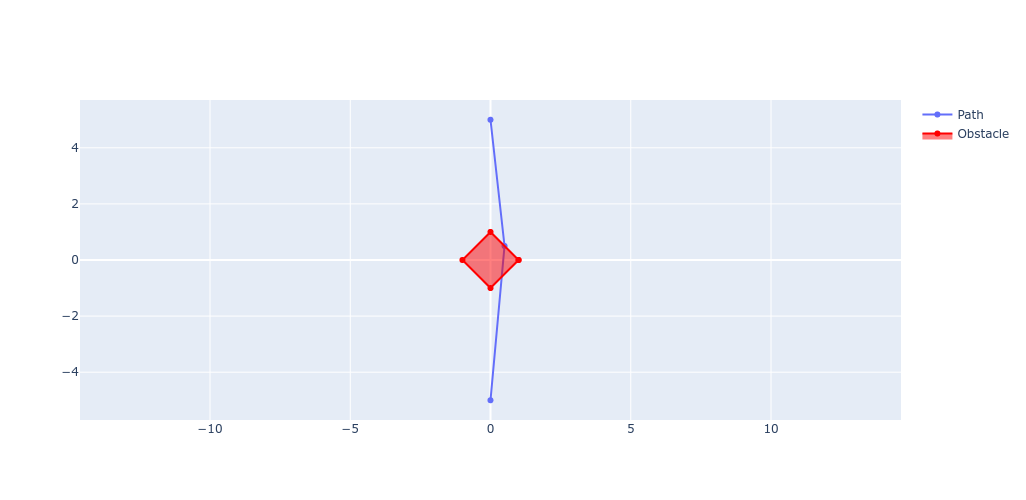

In [429]:
# L1 box obstacle example for single agent
# CVXPY MIQP example: https://www.cvxpy.org/examples/basic/mixed_integer_quadratic_program.html
# CVXPY trajectory optimization example: https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/intro/control.ipynb#scrollTo=fhczYBx97TRV

# Enter problem parameters here:
N = 3
k = 1
x_0 = [0, -5]
x_goal = [0, 5]

# For the agent to be outside of the box, one of these vectors dotted with the agent's position must be greater than one.
# cᵢ ⋅ xᵢ ≥ 1
# TODO: if you have multiple agents, do you just tile this matrix (repeat plane vectors for each agent), and then dot it with
# the whole state vector, or do you keep this the same and iterate through the agents upon constraint creation?
# TODO: I am a bit suspect of these constraints - the point [sqrt(2)/2, sqrt(2)/2] should be on the boundary of the box?
wall_plane_vectors = np.array([
    [1, 1],
    [-1, -1],
    [1, -1],
    [-1, 1],
])

# Define X vector: 1xn vector of position points in trajectory
x_dims = (2*k, N)
x = cp.Variable(x_dims)

# Define objective: sum of squared distance between points
cost = 0
for n in range(N - 1):
    # To find shortest path, minimize the distance between each steps
    cost += cp.sum_squares(x[:, n+1] - x[:, n])
objective = cp.Minimize(cost)

# Define intial and goal constraints
constr = []
constr += [x[:, 0] == x_0, x[:, N-1] == x_goal]

# Add obstacle constraints
M = 100000000
n_walls = len(wall_plane_vectors)
obs_dims = (n_walls, 1)
s = cp.Variable((n_walls, N), boolean=True)
ones_column = np.ones(obs_dims)
constr += [wall_plane_vectors @ x >= np.ones((n_walls, N)) - M*s, cp.sum(s, axis=0) <= len(wall_plane_vectors)-1]
                           
# Create and solve problem
scip_params={"numerics/feastol": 1e-12} # Need high accuracy of enforcing feasible sets for enforcing collision checking.

prob = cp.Problem(objective, constr)
prob.solve(solver="SCIP", scip_params=scip_params)

print("Status: ", prob.status)
print("The optimal cost is", prob.value)
print("A solution x is")
print(x.value)
print("Optimal s:")
print(s.value)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x.value[0, :],
    y=x.value[1, :],
    name="Path"
))

fig.add_trace(go.Scatter(
    x=[1, 0, -1, 0, 1],
    y=[0, 1, 0, -1, 0],
    fill="toself",
    name="Obstacle",
    line=dict(color="red")
))

fig.update_layout(yaxis_scaleanchor="x", width=600, height=500)
fig.show()

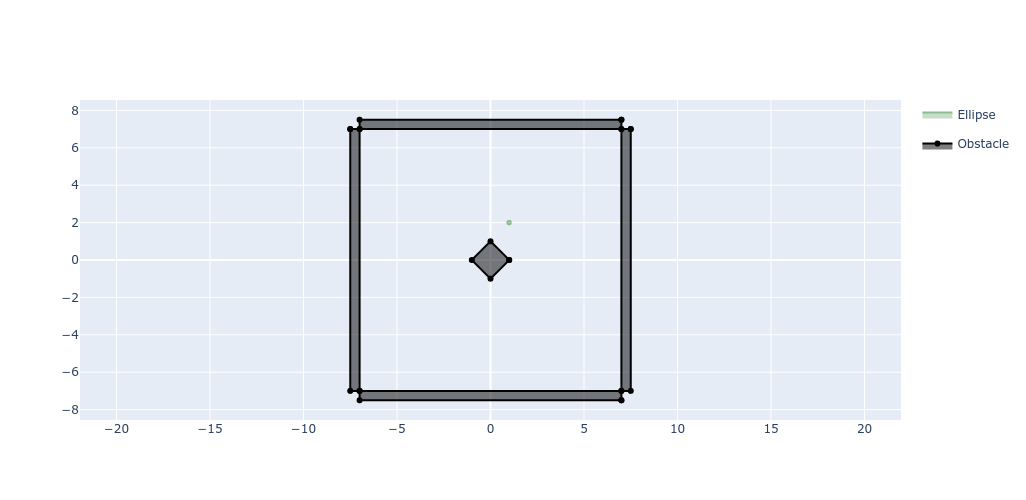

In [458]:
## Build a convex partitioning of the space with one square obstacle in it:
epsilon = 0.1
C_0 = np.eye(2) * epsilon
d_0 = np.array([[1, 2]]).T

obs_cube1 = np.array([
    [1, 0],
    [0, 1],
    [-1, 0],
    [0, -1],
]).T

r_wall = np.array([
    [7.5, 7],
    [7, 7],
    [7, -7],
    [7.5, -7],
]).T

t_wall = np.array([
    [7, 7.5],
    [-7, 7.5],
    [-7, 7],
    [7, 7],
]).T

l_wall = np.diag([-1, 1]) @ r_wall
b_wall = np.diag([1, -1]) @ t_wall

obs = [obs_cube1, r_wall, t_wall, l_wall, b_wall]

def plot_obs(obs, fig=go.Figure()):
    for i, obs_i in enumerate(obs):
        fig.add_trace(go.Scatter(
            x=np.concatenate([obs_i[0, :], [obs_i[0, 0]]]),
            y=np.concatenate([obs_i[1, :], [obs_i[1, 0]]]),
            # fill="toself",
            name="Obstacle",
            legendgroup="obstacle",
            showlegend=True if i == 0 else False,
            fill="toself",
            line=dict(color="black")
        ))
    return fig

def plot_ellipse(C, d, fig = go.Figure()):
    s = np.linspace(0, 2*np.pi, 20)
    unit_circle_pts = np.array([np.cos(s), np.sin(s)])
    
    ellipse_pts = C @ unit_circle_pts + d
    fig.add_trace(go.Scatter(
        x=ellipse_pts[0, :],
        y=ellipse_pts[1, :],
        fill="toself",
        line=dict(color="darkseagreen"),
        name="Ellipse"
    ))

    fig.update_layout(yaxis_scaleanchor="x", width=600, height=500)
    return fig
    
fig = go.Figure()
plot_ellipse(C_0, d_0, fig=fig)
plot_obs(obs, fig=fig)
fig.show()

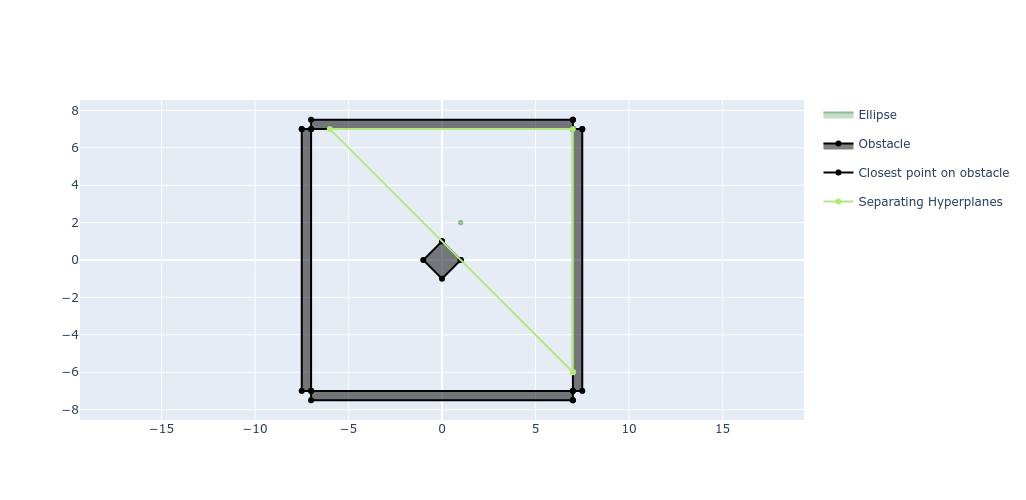

In [459]:
def find_hyperplanes(C, d, obs):
    # Step 1: Find separating hyperplanes which will allow further expansion of the ellipse:
    
    # For each obstacle, find the point on its boundary which is closest to the origin
    # by solving the quadratic program defined in Eqn.4 in Deits 2014
    # Note that x_tilde is in ball-space!
    n_obs = len(obs)
    A = np.zeros((n_obs, 2))
    b = np.zeros((n_obs, 1))
    x_stars = np.zeros((2, n_obs))
    
    # TODO: This can be optimized by checking at the end of each step if there are other obstacles separated by the 
    # the new plane, and then ignoring them in future steps.
    # TODO: This can be optimized by starting with the obstacle closest to the ellipse, working outward
    for j, obs_j in enumerate(obs):
        # Transform obstacle points from world frame into world-space into ball-space
        obs_j_ball_space = np.linalg.inv(C) @ (obs_j - d)
        
        # Find closest point in ball-space
        x_tilde = cp.Variable((2, 1))
        w = cp.Variable((obs_j.shape[1], 1), nonneg=True)
        obj = cp.Minimize(cp.sum_squares(x_tilde)) # Find point which is closest to origin
        constr = [obs_j_ball_space @ w == x_tilde, cp.sum(w) == 1] # Constrain x to inside of obstacle via convex combination of vertices
        prob = cp.Problem(obj, constr)
        prob.solve()

        # Transform the closest point in ball-space back to world space
        x_star_j = C @ x_tilde.value + d

        # Step 1b: Find a and b defining the plane tangent to ellipse which passes through x_star
        # Eqn 6 of Deits 2014
        C_inv = np.linalg.inv(C)
        A[j, :] = (2 * C_inv @ C_inv.T @ (x_star_j - d)).T
        b[j] = A[j,:] @ x_star_j
        
        x_stars[:, j] = np.squeeze(x_star_j)
    return A, b, x_stars

def plot_planes(A, b, d_0, fig=go.Figure()):
    hs = HalfspaceIntersection(np.hstack([A, -b]), d_0.flatten())
    fig.add_trace(go.Scatter(
        x=np.concatenate([hs.intersections[:, 0], [hs.intersections[0,0]]]),
        y=np.concatenate([hs.intersections[:, 1],[hs.intersections[0,1]]]),
        name="Separating Hyperplanes"
    ))
    return fig

A, b, x_stars = find_hyperplanes(C_0, d_0, obs)

fig = go.Figure()
plot_ellipse(C_0, d_0, fig)
plot_obs(obs, fig)

fig.add_trace(go.Scatter(
    x=x_star[0],
    y=x_star[1],
    name="Closest point on obstacle",
    marker=dict(color="black")
))

plot_planes(A, b, d_0, fig)
fig.show()

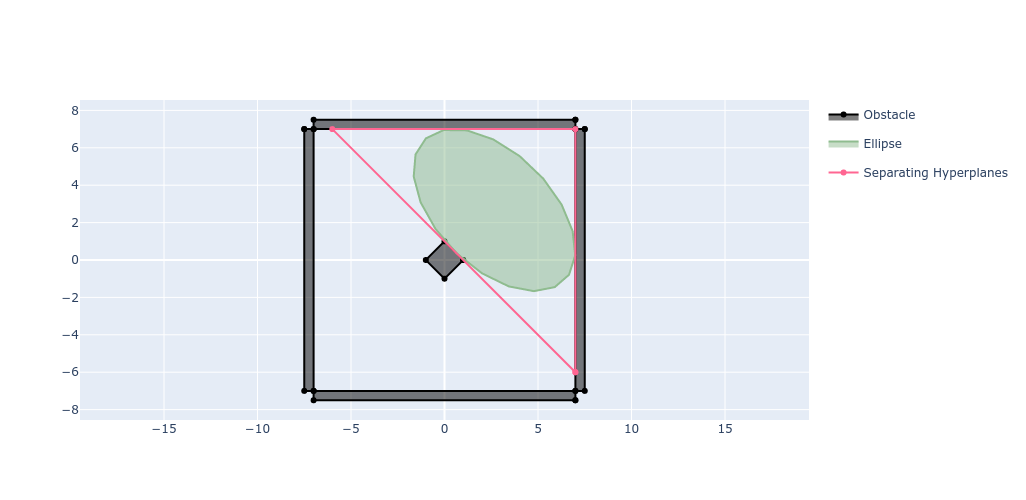

In [460]:
def maximize_ellipsoid(A, b):
    # Find the largest ellipsoid that can fit within the given set of planes
    # Implementation of the semidefinite program in Eq. 10 in Diets 2014.
    C = cp.Variable((2, 2), PSD=True)
    d = cp.Variable((2, 1))
    
    obj = cp.Maximize(cp.log_det(C))
    constr = []
    for i, a in enumerate(A):
        constr += [cp.norm(a @ C) + a @ d <= b[i]]
    
    prob = cp.Problem(obj, constr)
    prob.solve()
    
    return C.value, d.value

C, d = maximize_ellipsoid(A, b)
fig = go.Figure()
plot_obs(obs, fig)
plot_ellipse(C, d, fig)
plot_planes(A, b, d_0, fig)

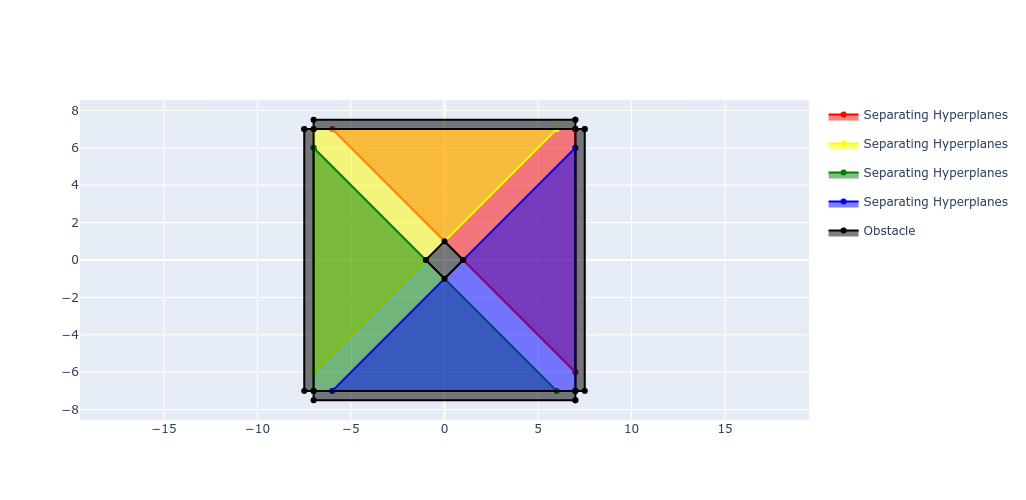

In [461]:
def convex_freespace_decomp(obs, n = 5):
    det_last = 0
    start_posns = np.array([
        [3,3],
        [-4,3],
        [-3,-3],
        [3,-3]
    ])
    
    As, bs, Cs, ds = [], [], [], []
    for start_posn in start_posns:
        d_0 = np.atleast_2d(start_posn).T
        C_0 = 0.1 * np.eye(2)
        
        last_C = C_0
        while True:
            A, b, x_stars = find_hyperplanes(C_0, d_0, obs)
            C, d = maximize_ellipsoid(A, b)
            
            f_log_det = lambda A: np.log(np.linalg.det(A))
            if (f_log_det(C) - f_log_det(last_C)) / f_log_det(last_C) <= 0.1:
                break
            last_C = C
            
        As.append(A)
        bs.append(b)
        Cs.append(C)
        ds.append(d)
        
    return As, bs, Cs, ds

As, bs, Cs, ds = convex_freespace_decomp(obs)

fig = go.Figure()
# for C,d in zip(Cs, ds):
#     plot_ellipse(C, d, fig)
    
marker_patterns = ["+","\\",".","/"]
colors=["red", "yellow", "green", "blue"]
for A, b, d_0, ptrn, color in zip(As, bs, ds, marker_patterns, colors):
    hs = HalfspaceIntersection(np.hstack([A, -b]), d_0.flatten())
    fig.add_trace(go.Scatter(
        x=np.concatenate([hs.intersections[:, 0], [hs.intersections[0,0]]]),
        y=np.concatenate([hs.intersections[:, 1],[hs.intersections[0,1]]]),
        # fillpattern=dict(shape=ptrn),
        fill="toself",
        line=dict(color=color),
        name="Separating Hyperplanes",
    ))
    
plot_obs(obs, fig)
fig.update_layout(yaxis_scaleanchor="x", width=600, height=500)
fig.show()

In [521]:
# Build the graph of convex sets
freespace_polys = []

for A_i, b_i, d_i in zip(As, bs, ds):
    hs = HalfspaceIntersection(np.hstack([A_i, -b_i]), d_i.flatten())
    freespace_polys.append(hs.intersections)
    
# Build adjacency matrix
n_polys = len(freespace_polys)
graph_adj = np.zeros((n_polys, n_polys))
for i, poly_i in enumerate(freespace_polys):
    intersecting = []
    for j, (A_j, b_j) in enumerate(zip(As, bs)):
        overlapping = np.any(A_j @ poly_i.T - b_j >= 1e-5)
        if overlapping:
            graph_adj[i, j] = 1

In [523]:
# Path planning over convex polytopes via Graphs of Convex Sets formulation
# Implementation of the Mixed-Integer Convex Program Eq. 5.5 from https://arxiv.org/pdf/2101.11565.pdf
# NOTE: we actually start with just an implementaiton of Eq. 5.2, which is non-convex but easier.

# Enter problem parameters here:
x_0 = [0, -5]
x_goal = [0, 5]

# Define decision variables
num_regions = len(A_i)
X = cp.Variable((num_regions, 1))
y = cp.Variable((num_regions, 1), boolean=True)